# Visual Defect Detection Using Transfer Learning
Description: This notebook implements a defect detection system using a pre-trained CNN (ResNet50) on the MVTec AD dataset.

## Step 1: Setup and Imports

In [24]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set path to your dataset folder
DATASET_PATH = '/content/drive/MyDrive/CSS586_Visual_Defect_Detection/datasets'


Mounted at /content/drive


In [25]:
# !pip install torchvision matplotlib scikit-learn

# Imports
import os
from glob import glob
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets
from torch.utils.data import DataLoader, random_split, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay

import numpy as np
from PIL import Image
import seaborn as sns


In [26]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Step 2: Data Preparation
Since MVTec AD dataset only has `train/good`, `test/good`, `test/defective`, you have to load the MVTec AD dataset fully and then split into train, test and validation datasets using a stratified split.

In [27]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [28]:
class MVTecBinaryClassificationDataset(Dataset):
    def __init__(self, root_dir=None, item_names='all', transform=None, paths=None, labels=None):
        self.transform = transform
        self.classes = ['good', 'defective']

        # Direct mode: from path-label pairs
        if paths is not None and labels is not None:
            self.samples = paths
            self.labels = labels
            return

        # Otherwise use the default directory-based mode
        self.samples = []
        self.labels = []

        # List all items if 'all' is passed
        if item_names == 'all':
            item_names = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

        if root_dir is None:
            raise ValueError("Must provide either (root_dir and item_names) or (paths and labels).")

        if isinstance(item_names, str):
            item_names = [item_names]  # Make it a list

        for item_name in item_names:
            base_path = os.path.join(root_dir, item_name)

            split = 'train'
            split_path = os.path.join(base_path, split)
            good_images = glob(os.path.join(split_path, 'good', '*.png'))
            self.samples += good_images
            self.labels += [0] * len(good_images)

            split = 'test'
            split_path = os.path.join(base_path, split)
            for defect_type in os.listdir(split_path):
                defect_path = os.path.join(split_path, defect_type)
                if not os.path.isdir(defect_path): continue
                images = glob(os.path.join(defect_path, '*.png'))
                label = 0 if defect_type == 'good' else 1
                self.samples += images
                self.labels += [label] * len(images)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path = self.samples[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [29]:
from sklearn.model_selection import train_test_split
item_name = 'bottle'  # Change this to the item you are evaluating
root_dir='/content/drive/MyDrive/CSS586_Visual_Defect_Detection/datasets/mvtec_anomaly_detection'

full_dataset = MVTecBinaryClassificationDataset(
    root_dir=root_dir,
    item_names=item_name,
    transform=None
)

class_2_id = {0:'good', 1:'defective'}

image_paths = full_dataset.samples
labels = full_dataset.labels

# First split: Train (80%) and temp (20%)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

# Second split: Val (10%) and Test (10%) from temp
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Datasets
train_dataset = MVTecBinaryClassificationDataset(paths=train_paths, labels=train_labels, transform=transform)
val_dataset = MVTecBinaryClassificationDataset(paths=val_paths, labels=val_labels, transform=transform)
test_dataset = MVTecBinaryClassificationDataset(paths=test_paths, labels=test_labels, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# Show class mapping
print("Class indices:", class_2_id)

Class indices: {0: 'good', 1: 'defective'}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [30]:
from collections import Counter

print("Train:", Counter(train_labels))
print("Val:", Counter(val_labels))
print("Test:", Counter(test_labels))

Train: Counter({0: 183, 1: 50})
Val: Counter({0: 23, 1: 6})
Test: Counter({0: 23, 1: 7})


##Step 3: Utility Functions
Define functions for getting, loading and saving checkpoints and metrics of the model in training.

In [31]:
import os
import re
import torch

CHECKPOINT_DIR = "/content/drive/MyDrive/CSS586_Visual_Defect_Detection/checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [32]:
def get_checkpoint_dir(experiment_name):
    base_dir = "/content/drive/MyDrive/CSS586_Visual_Defect_Detection/checkpoints"
    checkpoint_dir = os.path.join(base_dir, experiment_name)
    os.makedirs(checkpoint_dir, exist_ok=True)
    return checkpoint_dir

def load_latest_checkpoint(model, optimizer, experiment_name):
    checkpoint_dir = get_checkpoint_dir(experiment_name)
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith(".pth")]
    if not checkpoints:
        print(f"No checkpoint found for '{experiment_name}'. Starting from scratch.")
        return model, optimizer, 0

    latest = max(checkpoints, key=lambda f: int(re.findall(r'\d+', f)[-1]))
    path = os.path.join(checkpoint_dir, latest)
    print(f"Loading checkpoint from: {path}")
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    return model, optimizer, start_epoch

def save_checkpoint(model, optimizer, epoch, experiment_name):
    checkpoint_dir = get_checkpoint_dir(experiment_name)
    save_path = os.path.join(checkpoint_dir, f'resnet_vdd_epoch_{epoch}.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, save_path)
    print(f"Saved checkpoint to: {save_path}")

In [33]:
import json
def get_metrics_path(experiment_name):
    checkpoint_dir = get_checkpoint_dir(experiment_name)
    return os.path.join(checkpoint_dir, "metrics.json")

def save_metrics(train_losses, train_accs, val_accs, experiment_name):
    path = get_metrics_path(experiment_name)
    with open(path, "w") as f:
        json.dump({
            "train_losses": train_losses,
            "train_accs": train_accs,
            "val_accs": val_accs
        }, f)
    print(f"Saved metrics to: {path}")

def load_metrics(experiment_name):
    path = get_metrics_path(experiment_name)
    if os.path.exists(path):
        with open(path, "r") as f:
            data = json.load(f)
        print(f"Loaded existing metrics from: {path}")
        return data["train_losses"], data["train_accs"], data["val_accs"]
    else:
        print(f"No previous metrics found for '{experiment_name}', starting fresh.")
        return [], [], []

## Step 4: Load and Train the Baseline model: Single item category




In [34]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch.nn.functional as F

## --- Baseline Model: Simple CNN from Scratch ---
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  # 224/4 = 56 (after 2 pooling layers)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [35]:
# Training loop
def train_model(model, model_name, num_epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        # Training (same as existing code)
        model.train()
        total_loss, correct, total = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Validation (same as existing code)
        model.eval()
        val_correct, val_total = 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Print stats
        train_acc = correct / total
        val_acc = val_correct / val_total
        print(f"{model_name} Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss/len(train_loader):.4f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

    return model

In [42]:
# Evaluation
def evaluate_model(model, model_name):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Convert to arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\n{model_name} Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

    # Plot confusion matrix (reuse your existing visualization)
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()


    return all_preds,all_labels

In [43]:
def show_preds(model, loader, class_names, num_images=5):
    model.eval()
    shown = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                image = inputs[i].cpu().permute(1, 2, 0).numpy()
                image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
                image = np.clip(image, 0, 1)

                plt.imshow(image)
                plt.title(f"True: {class_names[labels[i]]} | Pred: {class_names[preds[i]]}")
                plt.axis('off')
                plt.show()

                shown += 1
                if shown >= num_images:
                    return


In [44]:
experiment_name = "multi_item_category_baseline".strip()
best_model_path = os.path.join(get_checkpoint_dir(experiment_name), f"best_model_{experiment_name}.pth")


Training Baseline CNN from Scratch...
Baseline CNN Epoch [1/10] - Loss: 6.4199 - Train Acc: 0.7854 - Val Acc: 0.2069
Baseline CNN Epoch [2/10] - Loss: 2.0136 - Train Acc: 0.5021 - Val Acc: 0.7931
Baseline CNN Epoch [3/10] - Loss: 0.5300 - Train Acc: 0.7854 - Val Acc: 0.7931
Baseline CNN Epoch [4/10] - Loss: 0.5402 - Train Acc: 0.7854 - Val Acc: 0.7931
Baseline CNN Epoch [5/10] - Loss: 0.5134 - Train Acc: 0.7854 - Val Acc: 0.7931
Baseline CNN Epoch [6/10] - Loss: 0.5059 - Train Acc: 0.7854 - Val Acc: 0.7931
Baseline CNN Epoch [7/10] - Loss: 0.5032 - Train Acc: 0.7854 - Val Acc: 0.7931
Baseline CNN Epoch [8/10] - Loss: 0.4852 - Train Acc: 0.7854 - Val Acc: 0.7931
Baseline CNN Epoch [9/10] - Loss: 0.4815 - Train Acc: 0.7854 - Val Acc: 0.7931
Baseline CNN Epoch [10/10] - Loss: 0.4667 - Train Acc: 0.7854 - Val Acc: 0.7931

Baseline CNN Test Accuracy: 0.7667

Classification Report:
              precision    recall  f1-score   support

        good       0.77      1.00      0.87        23
 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


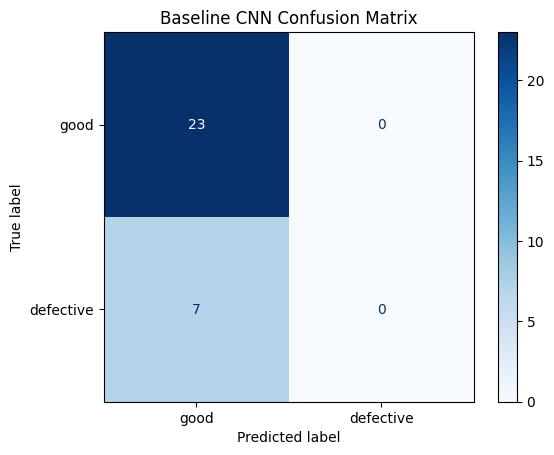

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


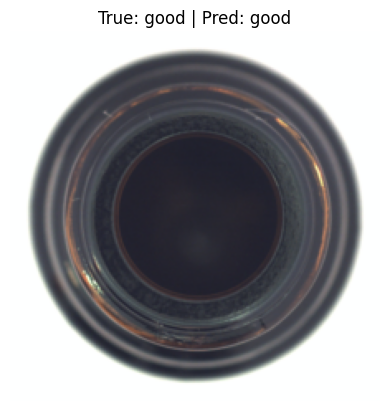

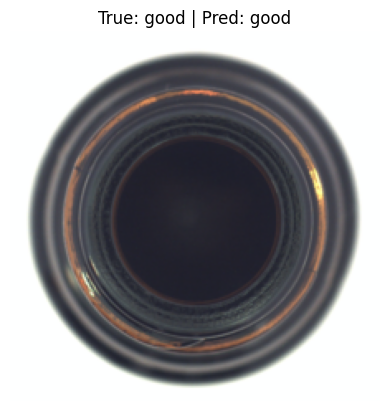

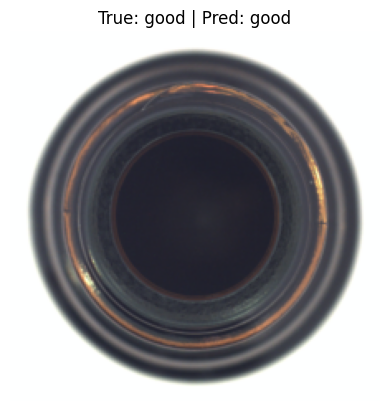

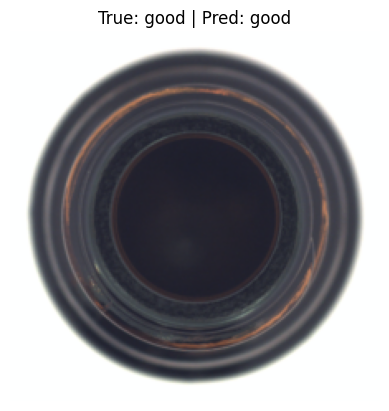

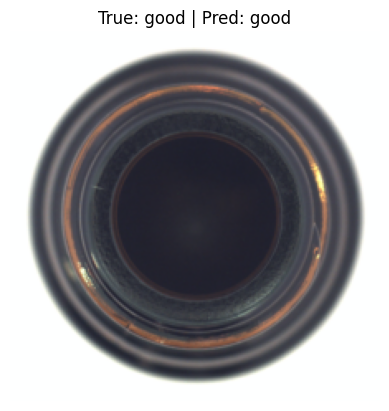

In [45]:
# Initialize model
scratch_model = SimpleCNN().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Train and evaluate baseline
print("\nTraining Baseline CNN from Scratch...")
scratch_model = train_model(scratch_model, "Baseline CNN")

test_preds, test_labels = evaluate_model(scratch_model, "Baseline CNN")

show_preds(scratch_model, test_loader, train_dataset.classes)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


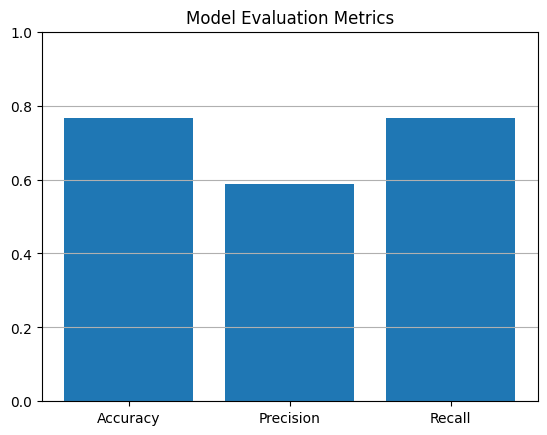

In [46]:
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds, average='weighted')
recall = recall_score(test_labels, test_preds, average='weighted')

plt.bar(['Accuracy', 'Precision', 'Recall'], [accuracy, precision, recall])
plt.title("Model Evaluation Metrics")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()

In [52]:
# Save full model (architecture + weights)
torch.save(scratch_model, f'/content/drive/MyDrive/CSS586_Visual_Defect_Detection/models/baseline_model.pth')
print(f"Model saved to /content/drive/MyDrive/CSS586_Visual_Defect_Detection/models/baseline_model.pth")

Model saved to /content/drive/MyDrive/CSS586_Visual_Defect_Detection/models/baseline_model.pth


#Baseline model: Multiple Item Category Training





## Step 2: Data Preparation
Using previously defined MVTecBinaryClassificationDataset class, load data and split into train, validation and test datasets (80:20:20)

In [47]:
item_name = 'all'

full_dataset = MVTecBinaryClassificationDataset(
    root_dir=root_dir,
    item_names=item_name,
    transform=None
)

image_paths = full_dataset.samples
labels = full_dataset.labels

# # First split: Train (80%) and temp (20%)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

# # Second split: Val (10%) and Test (10%) from temp
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Datasets
train_dataset = MVTecBinaryClassificationDataset(paths=train_paths, labels=train_labels, transform=transform)
val_dataset = MVTecBinaryClassificationDataset(paths=val_paths, labels=val_labels, transform=transform)
test_dataset = MVTecBinaryClassificationDataset(paths=test_paths, labels=test_labels, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# Show class mapping
print("Classes:", train_dataset.classes)
print("Total Images:", len(train_dataset)+len(val_dataset)+len(test_dataset))
print("Class indices:", class_2_id)

Classes: ['good', 'defective']
Total Images: 5354
Class indices: {0: 'good', 1: 'defective'}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [48]:
from collections import Counter

print("Train:", Counter(train_labels))
print("Val:", Counter(val_labels))
print("Test:", Counter(test_labels))


Train: Counter({0: 3277, 1: 1006})
Val: Counter({0: 409, 1: 126})
Test: Counter({0: 410, 1: 126})


In [49]:
experiment_name = "multi_item_category_baseline".strip()
best_model_path = os.path.join(get_checkpoint_dir(experiment_name), f"best_model_{experiment_name}.pth")


Training Baseline CNN from Scratch...
Baseline CNN Epoch [1/10] - Loss: 0.9215 - Train Acc: 0.7488 - Val Acc: 0.7645
Baseline CNN Epoch [2/10] - Loss: 0.5368 - Train Acc: 0.7647 - Val Acc: 0.7645
Baseline CNN Epoch [3/10] - Loss: 0.5142 - Train Acc: 0.7672 - Val Acc: 0.7645
Baseline CNN Epoch [4/10] - Loss: 0.4877 - Train Acc: 0.7731 - Val Acc: 0.7720
Baseline CNN Epoch [5/10] - Loss: 0.4336 - Train Acc: 0.8043 - Val Acc: 0.7794
Baseline CNN Epoch [6/10] - Loss: 0.3776 - Train Acc: 0.8340 - Val Acc: 0.7794
Baseline CNN Epoch [7/10] - Loss: 0.3287 - Train Acc: 0.8499 - Val Acc: 0.7383
Baseline CNN Epoch [8/10] - Loss: 0.2915 - Train Acc: 0.8690 - Val Acc: 0.7813
Baseline CNN Epoch [9/10] - Loss: 0.2536 - Train Acc: 0.8917 - Val Acc: 0.7720
Baseline CNN Epoch [10/10] - Loss: 0.2124 - Train Acc: 0.9071 - Val Acc: 0.7981

Baseline CNN Test Accuracy: 0.7817

Classification Report:
              precision    recall  f1-score   support

        good       0.80      0.95      0.87       410
 

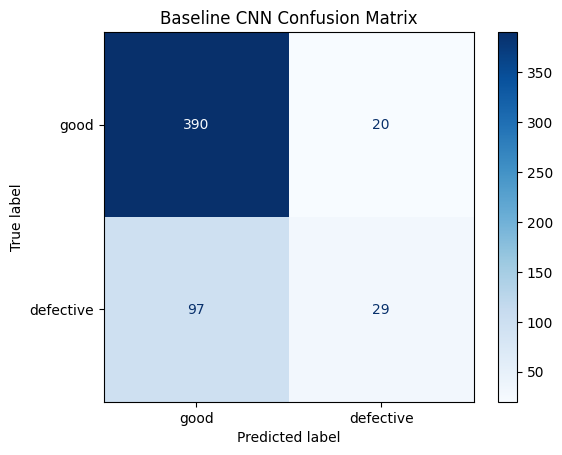

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


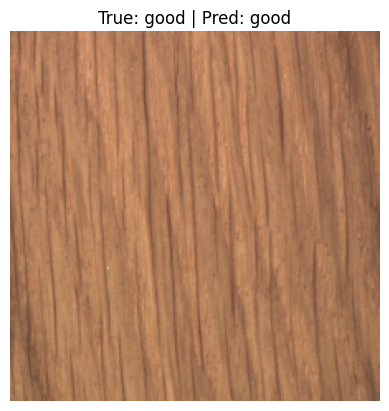

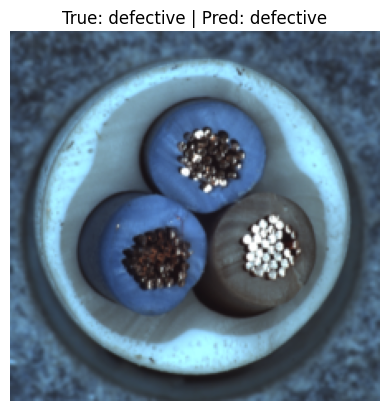

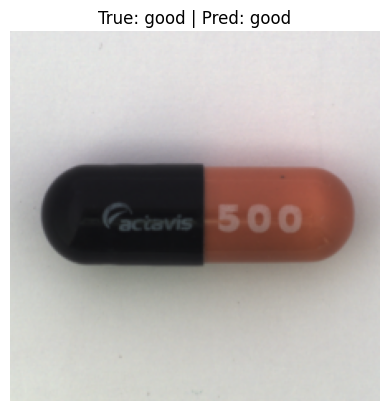

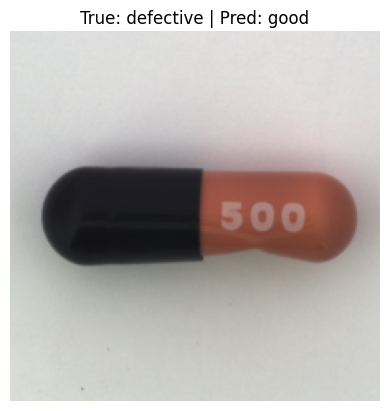

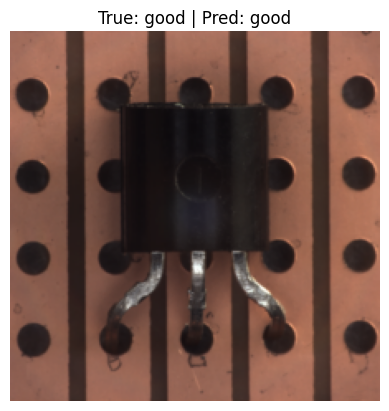

In [50]:
# Initialize model
scratch_model_multi = SimpleCNN().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Train and evaluate baseline
print("\nTraining Baseline CNN from Scratch...")
scratch_model_multi = train_model(scratch_model_multi, "Baseline CNN")

test_preds, test_labels = evaluate_model(scratch_model_multi, "Baseline CNN")

show_preds(scratch_model_multi, test_loader, train_dataset.classes)

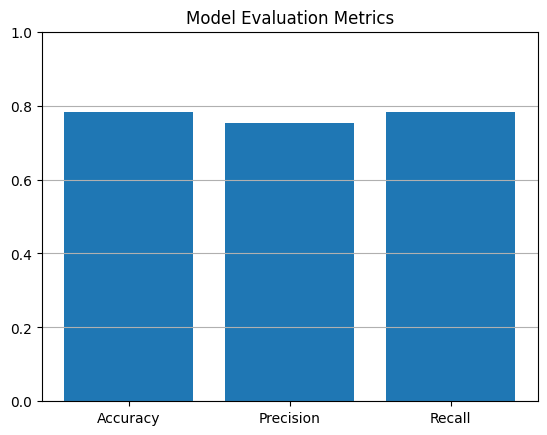

In [51]:
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds, average='weighted')
recall = recall_score(test_labels, test_preds, average='weighted')

plt.bar(['Accuracy', 'Precision', 'Recall'], [accuracy, precision, recall])
plt.title("Model Evaluation Metrics")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()

In [53]:
# Save full model (architecture + weights)
torch.save(scratch_model_multi, f'/content/drive/MyDrive/CSS586_Visual_Defect_Detection/models/baseline_model_multi.pth')
print(f"Model saved to /content/drive/MyDrive/CSS586_Visual_Defect_Detection/models/baseline_model_multi.pth")

Model saved to /content/drive/MyDrive/CSS586_Visual_Defect_Detection/models/baseline_model_multi.pth
